In [1]:
# Import libraries and dependencies
import os
import pandas as pd
import alpaca_trade_api as tradeapi
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from MCForecastTools import MCSimulation

from dotenv import load_dotenv
load_dotenv()

%matplotlib inline

In [2]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2"
)

In [3]:
# set tickers for Amazon, Facebook, NVidia, Walmart, and Goldman Sachs
ticker = ["AMZN", "FB", "NVDA", "WMT", "GS", "SNP"]


# Set timeframe to '1D'
timeframe = "1D"

# Set start and end datetimes of 1 year, between now and 365 days ago.
start_date = pd.Timestamp("2021-01-28", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2022-02-07", tz="America/New_York").isoformat()

# Get 1 year's worth of historical data for all tickers
df_ticker = alpaca.get_barset(
    ticker,
    timeframe,
    start=start_date,
    end=end_date,
    limit=1000,
).df

# Display sample data
df_ticker.head()

/opt/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecatedWarning: get_barset is deprecated as of v1.0.0. Use get_bars instead


AMZN                                       \
                              open     high       low    close   volume   
time                                                                      
2021-01-28 00:00:00-05:00  3235.04  3301.68  3228.690  3239.70  2742821   
2021-01-29 00:00:00-05:00  3230.00  3236.99  3184.550  3206.31  2855494   
2021-02-01 00:00:00-05:00  3242.36  3350.26  3235.025  3342.88  3734204   
2021-02-02 00:00:00-05:00  3380.00  3427.74  3361.125  3383.23  5024907   
2021-02-03 00:00:00-05:00  3425.01  3434.00  3308.620  3311.26  6445905   

                               FB                                    ...  \
                             open    high     low   close    volume  ...   
time                                                                 ...   
2021-01-28 00:00:00-05:00  277.18  286.79  264.70  265.00  35383730  ...   
2021-01-29 00:00:00-05:00  265.30  266.56  254.85  258.33  28139673  ...   
2021-02-01 00:00:00-05:00  259.52  264.17  254.91  261.98  19629047  ...   
2021-02-02 00:00:00-05:00  264.00  268.85  263.27  267.00  15002887  ...   
2021-02-03 00:00:00-05:00  265.62  269.20  263.84  266.68  13254318  ...   

                             SNP                                  WMT          \
                            open   high    low  close  volume    open    high   
time                                                                            
2021-01-28 00:00:00-05:00  48.79  49.20  48.31  48.71  174384  144.46  146.26   
2021-01-29 00:00:00-05:00  48.02  48.20  47.31  47.42  108463  143.18  143.75   
2021-02-01 00:00:00-05:00  47.98  48.29  47.59  48.00  118111  140.91  141.49   
2021-02-02 00:00:00-05:00  48.64  48.82  48.20  48.64  112467  139.76  142.15   
2021-02-03 00:00:00-05:00  48.81  49.01  48.60  48.94  100934  140.66  142.05   

                                                        
                                low     close   volume  
time                                                    
2021-01-28 00:00:00-05:00  143.6300  143.7000  6207997  
2021-01-29 00:00:00-05:00  140.3500  140.4693  8553315  
2021-02-01 00:00:00-05:00  139.1900  139.2400  7663421  
2021-02-02 00:00:00-05:00  139.4401  140.7700  8332687  
2021-02-03 00:00:00-05:00  140.6300  141.1900  4483616  

[5 rows x 30 columns]

In [4]:
# Create an empty DataFrame for closing prices
df_closing_prices = pd.DataFrame()

# Fetch the closing prices of all stocks
df_closing_prices["AMZN"] = df_ticker["AMZN"]["close"]
df_closing_prices["FB"] = df_ticker["FB"]["close"]
df_closing_prices["NVDA"] = df_ticker["NVDA"]["close"]
df_closing_prices["WMT"] = df_ticker["WMT"]["close"]
df_closing_prices["GS"] = df_ticker["GS"]["close"]
df_closing_prices["SNP"] = df_ticker["SNP"]["close"]

# Drop the time component of the date
df_closing_prices.index = df_closing_prices.index.date

# Compute daily returns
df_daily_returns = df_closing_prices.pct_change().dropna()

# Display sample data
df_daily_returns.head()

,AMZN,FB,NVDA,WMT,GS,SNP
2021-01-29,-0.010307,-0.025170,-0.005556,-0.022482,-0.014142,-0.026483
2021-02-01,0.042594,0.014129,0.020134,-0.008751,0.012685,0.012231
2021-02-02,0.012070,0.019162,0.024175,0.010988,0.044716,0.013333
2021-02-03,-0.021273,-0.001199,-0.002139,0.002984,0.005716,0.006168
2021-02-04,0.005913,-0.000187,0.010072,0.009491,0.019339,-0.003882


In [5]:
# Generate descriptive statistics
df_daily_returns.describe()

,AMZN,FB,NVDA,WMT,GS,SNP
count,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000
mean,0.000070,-0.000293,0.000023,-0.000100,0.001258,0.000538
std,0.018473,0.024937,0.055232,0.010649,0.016181,0.017339
min,-0.077628,-0.263653,-0.752313,-0.066287,-0.070219,-0.054496
25%,-0.009057,-0.010868,-0.013402,-0.005971,-0.010171,-0.009826
50%,-0.000056,-0.000122,0.002860,0.000215,0.000484,0.001143
75%,0.010176,0.013770,0.020095,0.006487,0.011649,0.011082
max,0.134647,0.072938,0.120540,0.028626,0.044716,0.069929


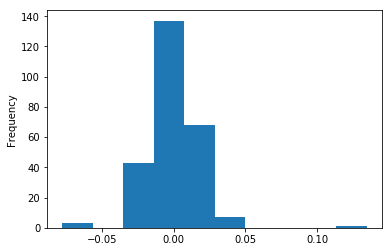

In [6]:
# Visualize distribution of Amazon percent change in closing price using a histogram plot
df_daily_returns["AMZN"].plot.hist() 

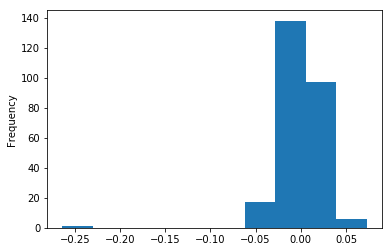

In [7]:
# Visualize distribution of FaceBook percent change in closing price using a histogram plot
df_daily_returns["FB"].plot.hist()

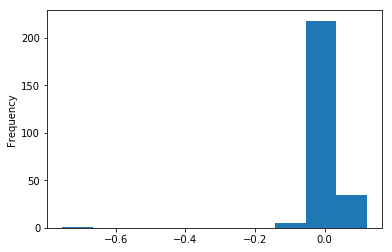

In [8]:
# Visualize distribution of NVidia percent change in closing price using a histogram plot
df_daily_returns["NVDA"].plot.hist()

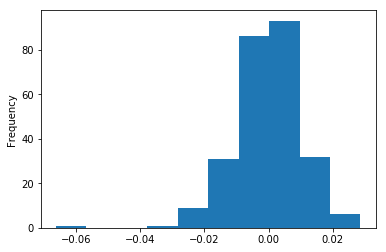

In [9]:
# Visualize distribution of WalMart percent change in closing price using a histogram plot
df_daily_returns["WMT"].plot.hist()

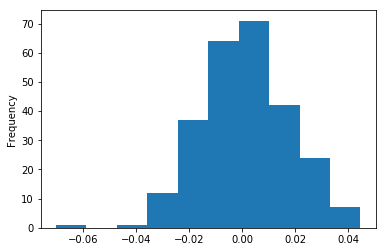

In [10]:
# Visualize distribution of Goldman Sachs percent change in closing price using a histogram plot
df_daily_returns["GS"].plot.hist()

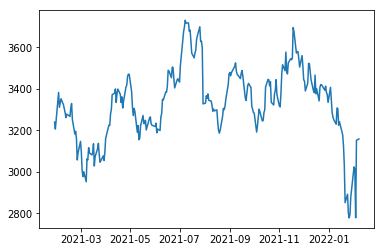

In [11]:
df_closing_prices["AMZN"].plot()

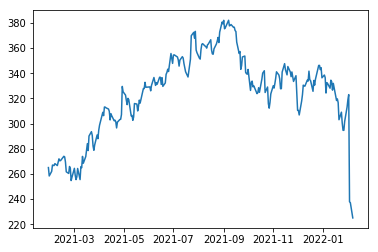

In [12]:
df_closing_prices["FB"].plot()

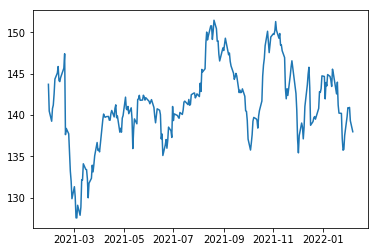

In [13]:
df_closing_prices["WMT"].plot()

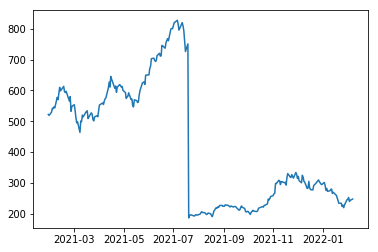

In [14]:
df_closing_prices["NVDA"].plot()

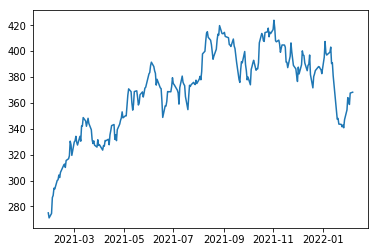

In [15]:
df_closing_prices["GS"].plot()

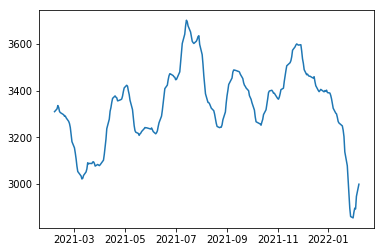

In [16]:
# Plot a rolling 7-day mean of Amazon closing prices
df_closing_prices["AMZN"].rolling(window=7).mean().plot()

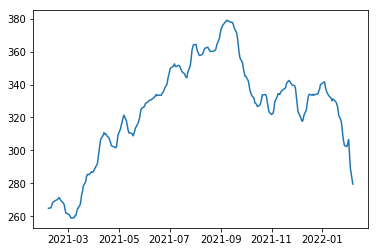

In [17]:
# Plot a rolling 7-day mean of FaceBook closing prices
df_closing_prices["FB"].rolling(window=7).mean().plot()

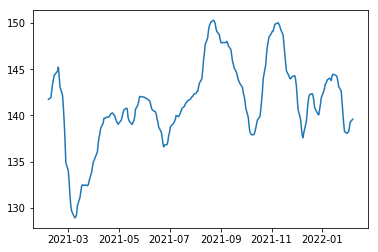

In [18]:
# Plot a rolling 7-day mean of WalMArt closing prices
df_closing_prices["WMT"].rolling(window=7).mean().plot()

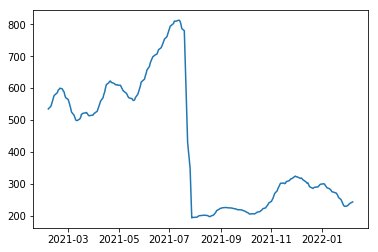

In [19]:
# Plot a rolling 7-day mean of NVidia closing prices
df_closing_prices["NVDA"].rolling(window=7).mean().plot()

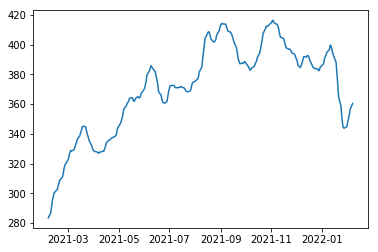

In [20]:
# Plot a rolling 7-day mean of Goldman Sachs closing prices
df_closing_prices["GS"].rolling(window=7).mean().plot()

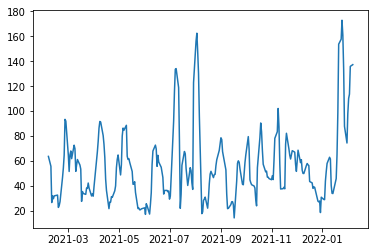

In [21]:
# Plot a rolling 7-day std dev of Amazon closing prices
df_closing_prices["AMZN"].rolling(window=7).std().plot()

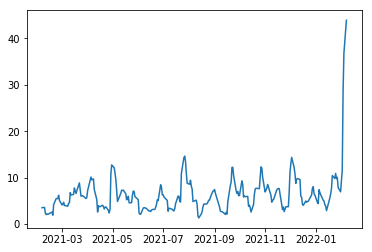

In [22]:
# Plot a rolling 7-day std dev of FaceBook closing prices
df_closing_prices["FB"].rolling(window=7).std().plot()

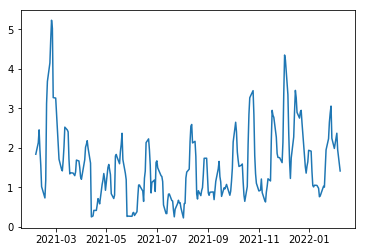

In [23]:
# Plot a rolling 7-day std dev of WalMart closing prices
df_closing_prices["WMT"].rolling(window=7).std().plot()

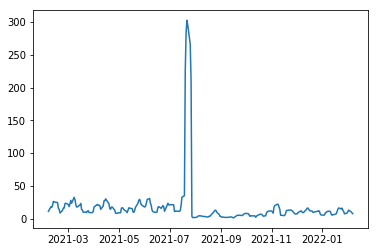

In [24]:
# Plot a rolling 7-day std dev of NVidia closing prices
df_closing_prices["NVDA"].rolling(window=7).std().plot()

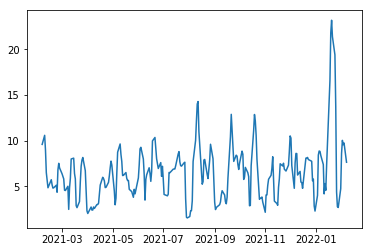

In [25]:
# Plot a rolling 7-day std dev of Goldman Sachs closing prices
df_closing_prices["GS"].rolling(window=7).std().plot()

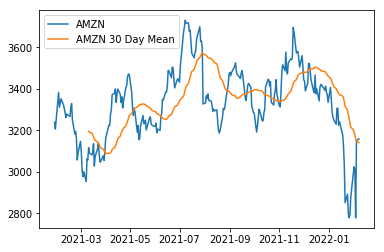

In [26]:
# Set figure of the daily closing prices of AMZN
ax = df_closing_prices["AMZN"].plot()

# Plot 180-Day Rolling Mean on the same figure
df_closing_prices["AMZN"].rolling(window=30).mean().plot(ax=ax)

# Set the legend of the figure
ax.legend(["AMZN", "AMZN 30 Day Mean"])

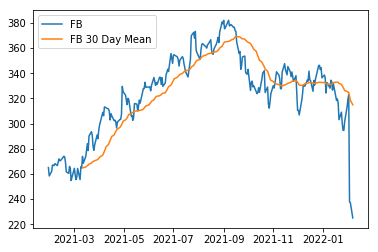

In [27]:
# Set figure of the daily closing prices of FB
ax = df_closing_prices["FB"].plot()

# Plot 180-Day Rolling Mean on the same figure
df_closing_prices["FB"].rolling(window=30).mean().plot(ax=ax)

# Set the legend of the figure
ax.legend(["FB", "FB 30 Day Mean"])

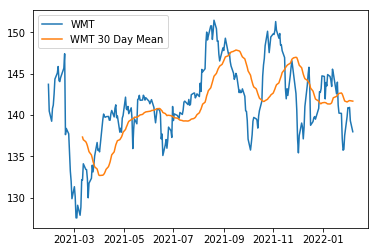

In [28]:
# Set figure of the daily closing prices of WMT
ax = df_closing_prices["WMT"].plot()

# Plot 180-Day Rolling Mean on the same figure
df_closing_prices["WMT"].rolling(window=30).mean().plot(ax=ax)

# Set the legend of the figure
ax.legend(["WMT", "WMT 30 Day Mean"])

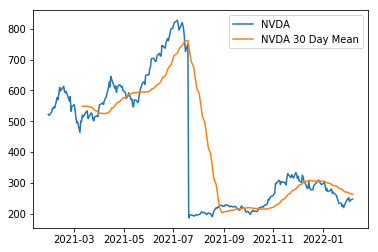

In [29]:
# Set figure of the daily closing prices of NVDA
ax = df_closing_prices["NVDA"].plot()

# Plot 180-Day Rolling Mean on the same figure
df_closing_prices["NVDA"].rolling(window=30).mean().plot(ax=ax)

# Set the legend of the figure
ax.legend(["NVDA", "NVDA 30 Day Mean"])

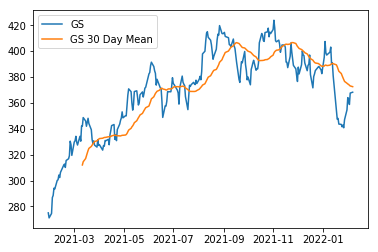

In [30]:
# Set figure of the daily closing prices of GS
ax = df_closing_prices["GS"].plot()

# Plot 180-Day Rolling Mean on the same figure
df_closing_prices["GS"].rolling(window=30).mean().plot(ax=ax)

# Set the legend of the figure
ax.legend(["GS", "GS 30 Day Mean"])

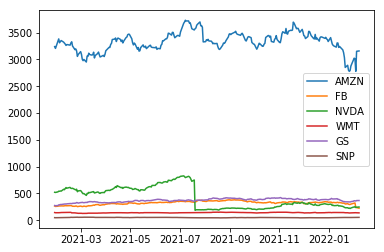

In [31]:
df_closing_prices.plot()

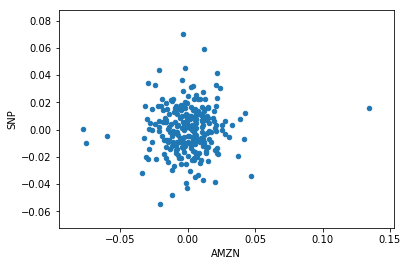

In [32]:
df_daily_returns.plot(kind='scatter', x='AMZN', y='SNP')

In [33]:
# Calculate covariance of all daily returns of AMZN vs. SNP
covariance = df_daily_returns['AMZN'].cov(df_daily_returns['SNP'])
covariance

1.4729151041472805e-05

In [34]:
# Calculate variance of the S&P 500
variance = df_daily_returns['SNP'].var()
variance

0.00030064243060146963

In [35]:
# Calculate beta of all daily returns of AMZN
AMZN_beta = covariance / variance
AMZN_beta

0.04899225638911132

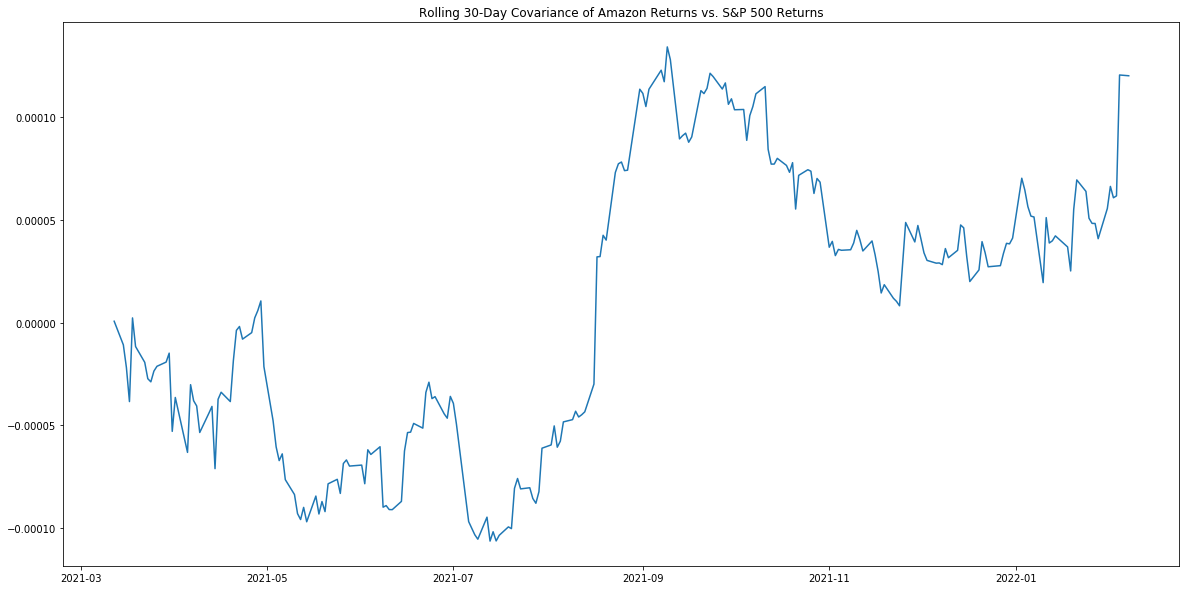

In [36]:
# Calculate 30-day rolling covariance of AMZN vs. SPN and plot the data
AMZN_rolling_covariance = df_daily_returns['AMZN'].rolling(window=30).cov(df_daily_returns['SNP'])
AMZN_rolling_covariance.plot(figsize=(20, 10), title='Rolling 30-Day Covariance of Amazon Returns vs. S&P 500 Returns')

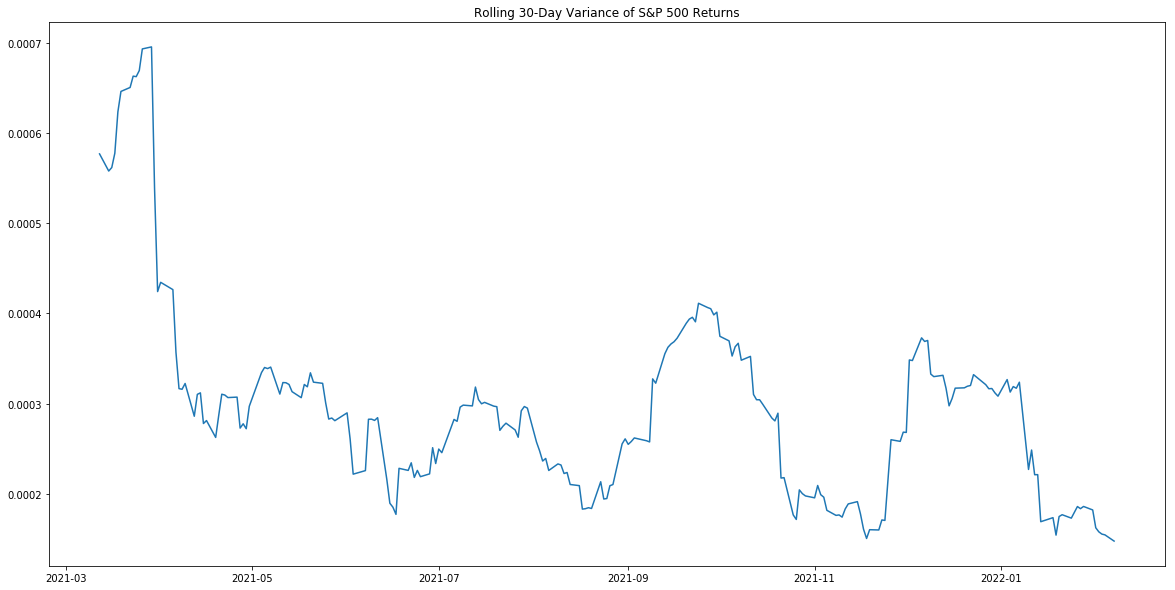

In [37]:
# Calculate 30-day rolling variance of MSFT vs. S&P 500 and plot the data
rolling_variance = df_daily_returns['SNP'].rolling(window=30).var()
rolling_variance.plot(figsize=(20, 10), title='Rolling 30-Day Variance of S&P 500 Returns')

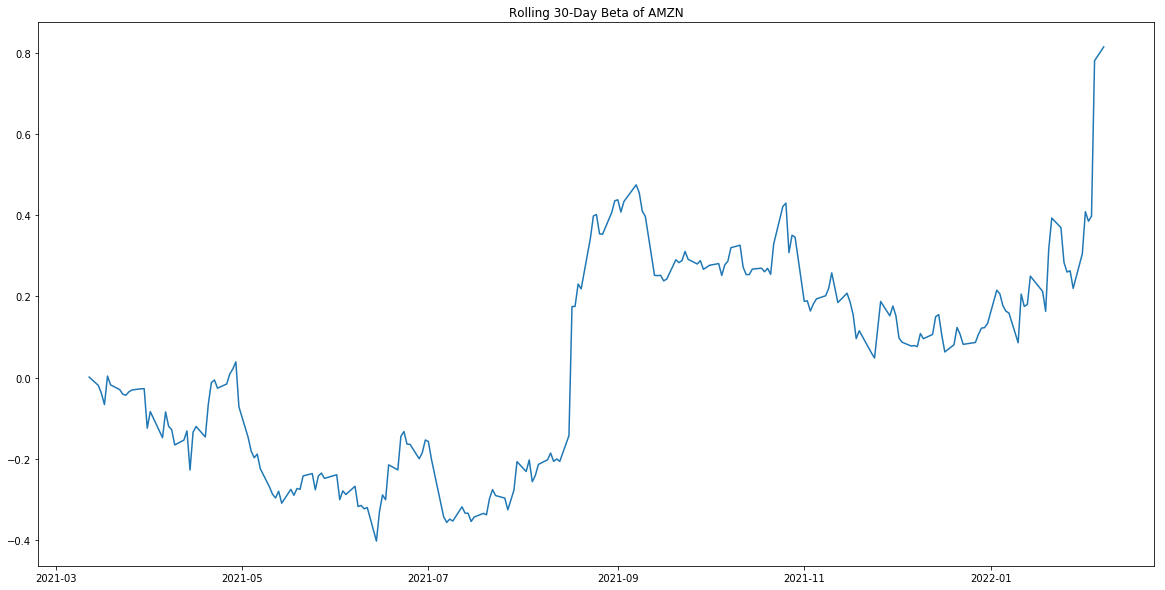

In [38]:
# Calculate 30-day rolling beta of MSFT and plot the data
rolling_beta = AMZN_rolling_covariance / rolling_variance
rolling_beta.plot(figsize=(20, 10), title='Rolling 30-Day Beta of AMZN')

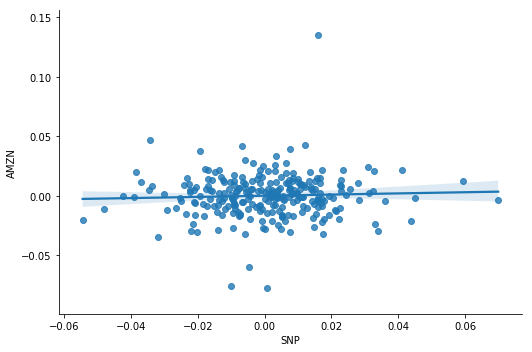

In [39]:
# Showcase beta vs. correlation by plotting a scatterplot using the seaborn library and fitting a regression line
sns.lmplot(x='SNP', y='AMZN', data=df_daily_returns, aspect=1.5, fit_reg=True)

In [40]:
# cumulative returns
cumulative_returns = (1 + df_daily_returns).cumprod() 
cumulative_returns.head()

,AMZN,FB,NVDA,WMT,GS,SNP
2021-01-29,0.989693,0.974830,0.994444,0.977518,0.985858,0.973517
2021-02-01,1.031849,0.988604,1.014466,0.968963,0.998364,0.985424
2021-02-02,1.044303,1.007547,1.038990,0.979610,1.043007,0.998563
2021-02-03,1.022088,1.006340,1.036767,0.982533,1.048969,1.004722
2021-02-04,1.028132,1.006151,1.047209,0.991858,1.069255,1.000821


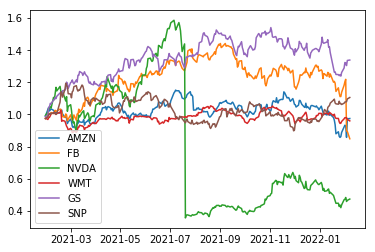

In [41]:
cumulative_returns.plot()

In [42]:
# Use the `std` function and multiply by the square root of the number of trading days in a year to get annualized volatility
volatility = df_daily_returns.std() * np.sqrt(252)
volatility.sort_values(inplace=True)
volatility

WMT     0.169041
GS      0.256859
SNP     0.275249
AMZN    0.293254
FB      0.395866
NVDA    0.876788
dtype: float64

In [43]:
portfolio_tickers = df_daily_returns.drop(columns="SNP")
portfolio_tickers

,AMZN,FB,NVDA,WMT,GS
2021-01-29,-0.010307,-0.025170,-0.005556,-0.022482,-0.014142
2021-02-01,0.042594,0.014129,0.020134,-0.008751,0.012685
2021-02-02,0.012070,0.019162,0.024175,0.010988,0.044716
2021-02-03,-0.021273,-0.001199,-0.002139,0.002984,0.005716
2021-02-04,0.005913,-0.000187,0.010072,0.009491,0.019339
...,...,...,...,...,...
2022-02-01,0.010885,0.018584,0.005550,0.007725,0.026735
2022-02-02,-0.003992,0.012539,0.024554,-0.000284,-0.002774
2022-02-03,-0.077628,-0.263653,-0.051416,0.000497,-0.011761
2022-02-04,0.134647,-0.003195,0.015284,-0.011497,0.024527


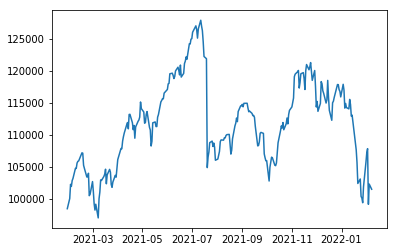

In [44]:
# Set weights for corresponding risk profile of stocks, use the `dot` function to multiply each weight by the corresponding stock daily return
# plot cumulative portfolio returns
initial_invest=100000
weights = [0.2, 0.2, 0.2, 0.2, 0.2]
portfolio_returns = portfolio_tickers.dot(weights)
cumulative_portfolio_returns = (1 + portfolio_returns).cumprod()
(initial_invest *  cumulative_portfolio_returns).plot()


In [45]:
correlation = df_daily_returns.corr()
correlation

,AMZN,FB,NVDA,WMT,GS,SNP
AMZN,1.000000,0.508835,0.264420,0.097366,0.172520,0.045984
FB,0.508835,1.000000,0.193804,0.207924,0.176151,0.094344
NVDA,0.264420,0.193804,1.000000,0.055603,0.027204,0.038788
WMT,0.097366,0.207924,0.055603,1.000000,0.194060,0.113250
GS,0.172520,0.176151,0.027204,0.194060,1.000000,0.283282
SNP,0.045984,0.094344,0.038788,0.113250,0.283282,1.000000


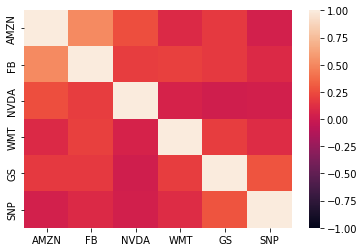

In [46]:
sns.heatmap(correlation, vmin=-1, vmax=1)

In [47]:
correlation.sum(axis=0).sort_values()

SNP     1.575648
NVDA    1.579820
WMT     1.668202
GS      1.853217
AMZN    2.089125
FB      2.181057
dtype: float64

In [48]:
# Use the `mean` and `std` functions to calculate the annualized sharpe ratio
sharpe_ratios = (df_daily_returns.mean() * 252) / (df_daily_returns.std() * np.sqrt(252))
sharpe_ratios

AMZN    0.060553
FB     -0.186437
NVDA    0.006597
WMT    -0.149356
GS      1.233795
SNP     0.492179
dtype: float64

In [49]:
AMZN_sma_100 = df_closing_prices["AMZN"].rolling(window=100).mean()
AMZN_sma_50 = df_closing_prices["AMZN"].rolling(window=50).mean()
AMZN_sma_20 = df_closing_prices["AMZN"].rolling(window=20).mean()
AMZN_ewm_7 = df_closing_prices["AMZN"].ewm(span=7).mean()
FB_sma_100 = df_closing_prices["FB"].rolling(window=100).mean()
FB_sma_50 = df_closing_prices["FB"].rolling(window=50).mean()
FB_sma_20 = df_closing_prices["FB"].rolling(window=20).mean()
FB_ewm_7 = df_closing_prices["FB"].ewm(span=7).mean()
WMT_sma_100 = df_closing_prices["WMT"].rolling(window=100).mean()
WMT_sma_50 = df_closing_prices["WMT"].rolling(window=50).mean()
WMT_sma_20 = df_closing_prices["WMT"].rolling(window=20).mean()
WMT_ewm_7 = df_closing_prices["WMT"].ewm(span=7).mean()
NVDA_sma_100 = df_closing_prices["NVDA"].rolling(window=100).mean()
NVDA_sma_50 = df_closing_prices["NVDA"].rolling(window=50).mean()
NVDA_sma_20 = df_closing_prices["NVDA"].rolling(window=20).mean()
NVDA_ewm_7 = df_closing_prices["NVDA"].ewm(span=7).mean()
GS_sma_100 = df_closing_prices["GS"].rolling(window=100).mean()
GS_sma_50 = df_closing_prices["GS"].rolling(window=50).mean()
GS_sma_20 = df_closing_prices["GS"].rolling(window=20).mean()
GS_ewm_7 = df_closing_prices["GS"].ewm(span=7).mean()

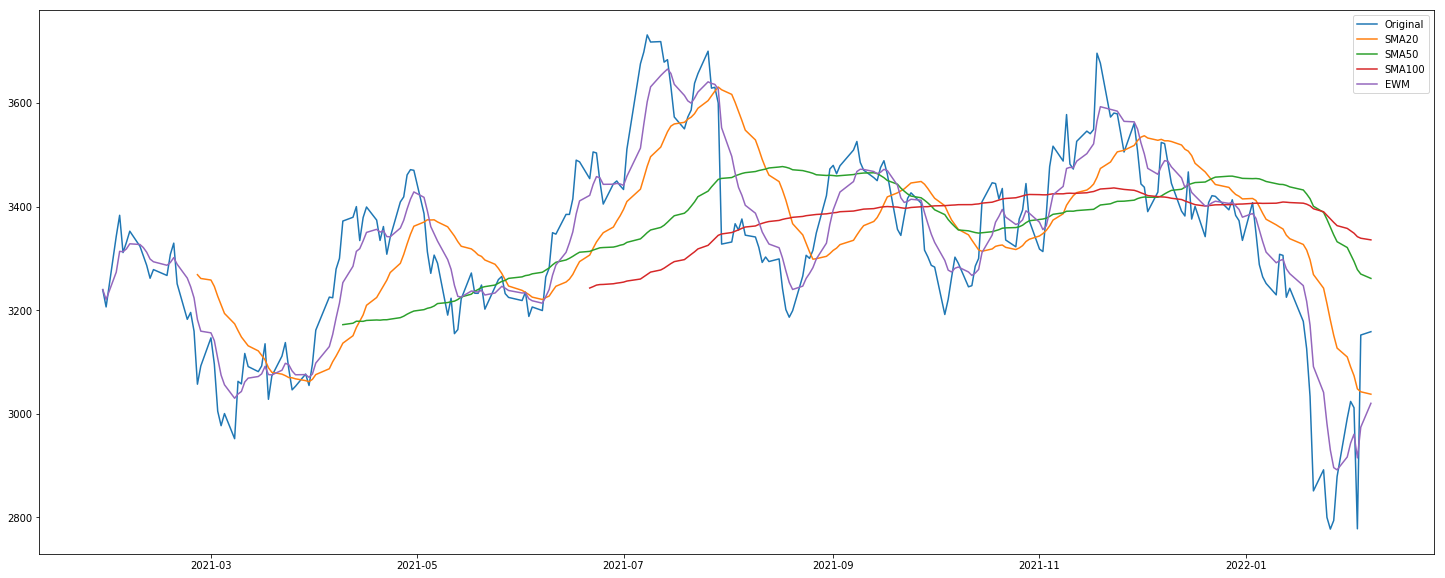

In [50]:
# Set figure of the daily closing prices of AMZN
ax = df_closing_prices["AMZN"].plot(figsize=(25,10))

# Overlay SMA20, SMA50, and SMA100 on the same figure
AMZN_sma_20.plot(ax=ax)
AMZN_sma_50.plot(ax=ax)
AMZN_sma_100.plot(ax=ax)
AMZN_ewm_7.plot(ax=ax)

# Set the legend of the figure
ax.legend(["Original", "SMA20", "SMA50", "SMA100", "EWM"]);

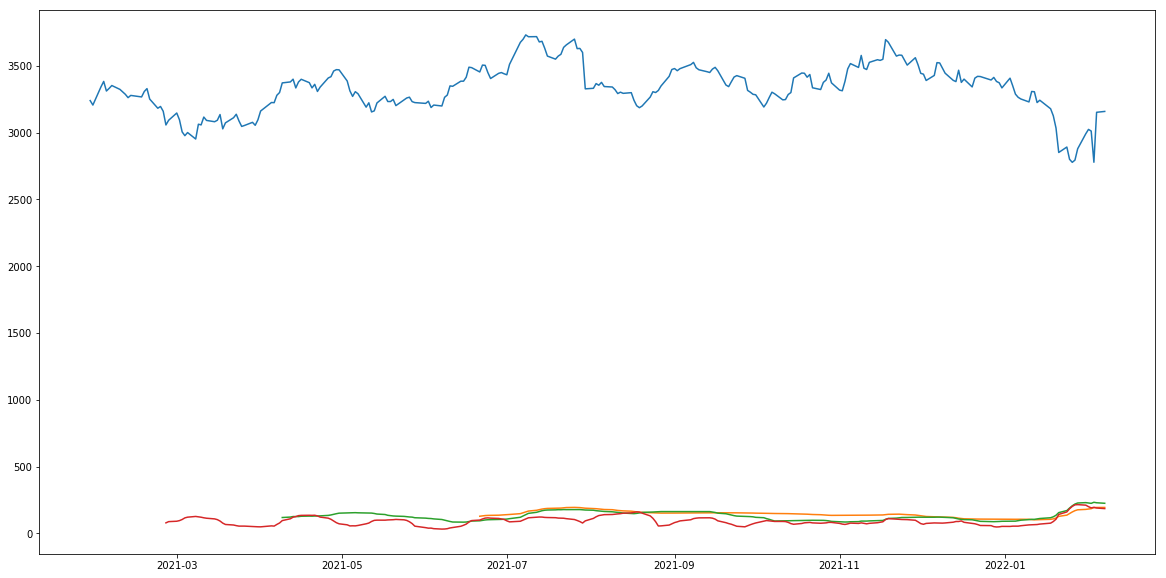

In [51]:
AMZN_100_std = df_closing_prices["AMZN"].rolling(window=100).std()
AMZN_50_std = df_closing_prices["AMZN"].rolling(window=50).std()
AMZN_20_std = df_closing_prices["AMZN"].rolling(window=20).std()

ax2 = df_closing_prices["AMZN"].plot(figsize=(20,10))
AMZN_100_std.plot(ax=ax2)
AMZN_50_std.plot(ax=ax2)
AMZN_20_std.plot(ax=ax2)

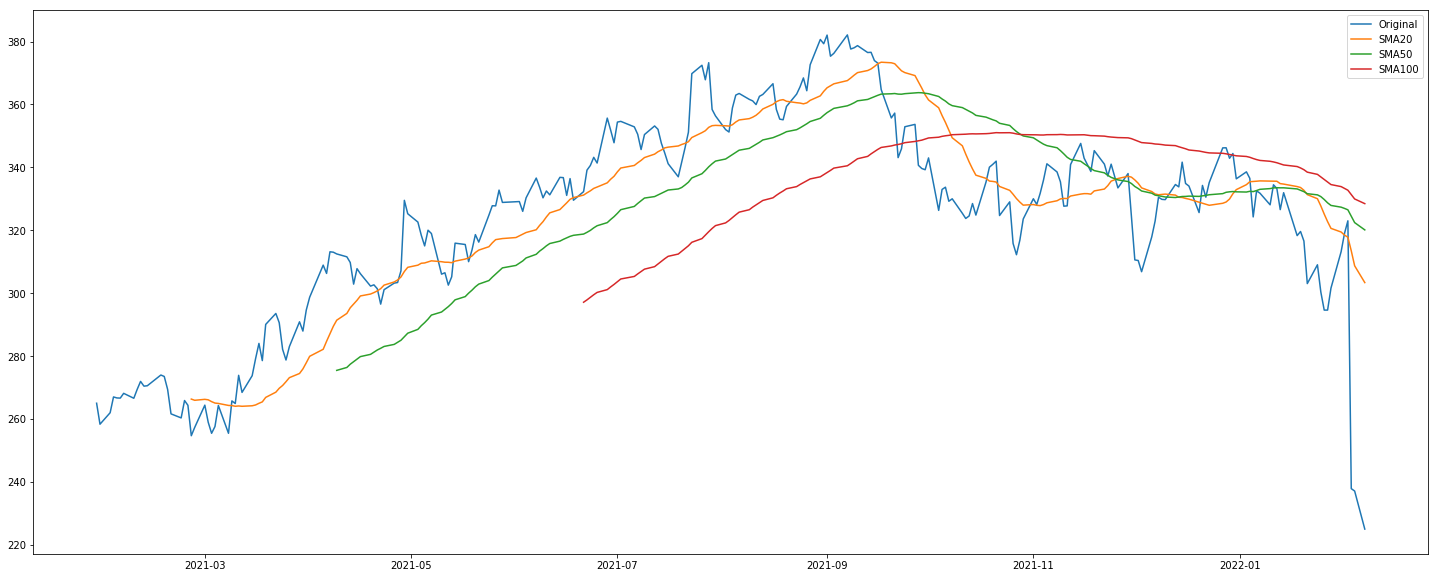

In [52]:
# Set figure of the daily closing prices of FB
ax = df_closing_prices["FB"].plot(figsize=(25,10))

# Overlay SMA20, SMA50, and SMA100 on the same figure
FB_sma_20.plot(ax=ax)
FB_sma_50.plot(ax=ax)
FB_sma_100.plot(ax=ax)

# Set the legend of the figure
ax.legend(["Original", "SMA20", "SMA50", "SMA100"]);

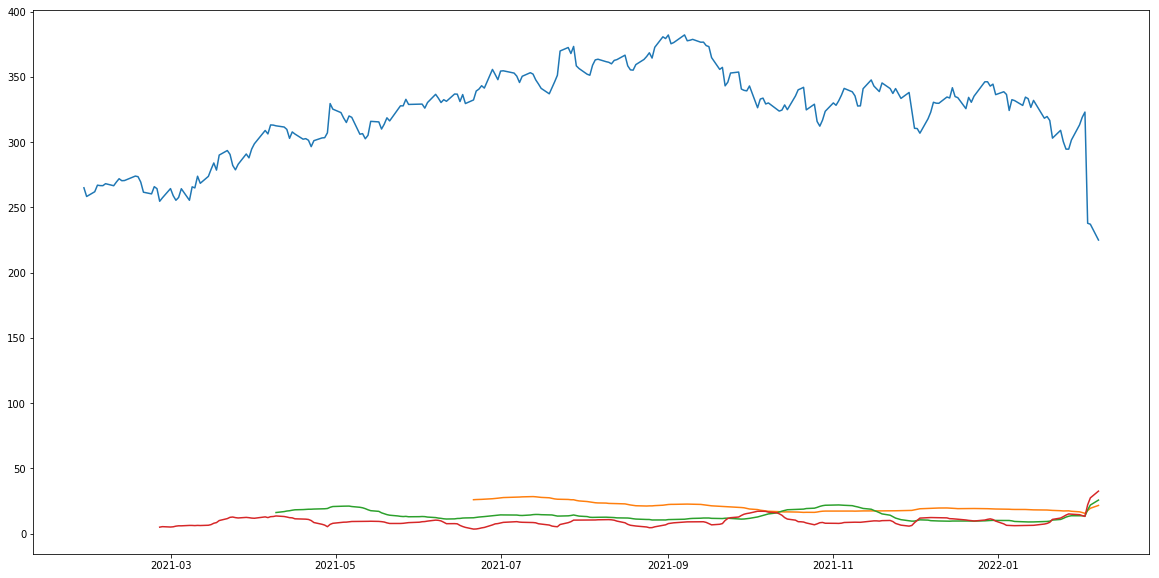

In [53]:
FB_100_std = df_closing_prices["FB"].rolling(window=100).std()
FB_50_std = df_closing_prices["FB"].rolling(window=50).std()
FB_20_std = df_closing_prices["FB"].rolling(window=20).std()

ax2 = df_closing_prices["FB"].plot(figsize=(20,10))
FB_100_std.plot(ax=ax2)
FB_50_std.plot(ax=ax2)
FB_20_std.plot(ax=ax2)

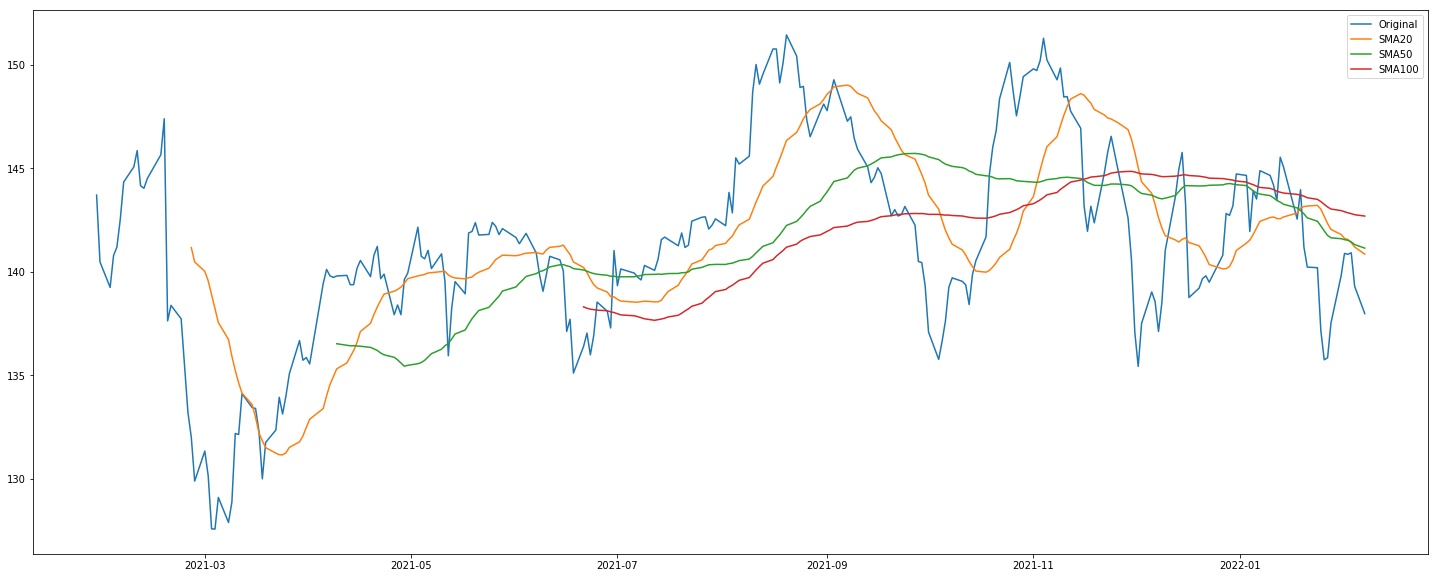

In [54]:
# Set figure of the daily closing prices of WMT
ax = df_closing_prices["WMT"].plot(figsize=(25,10))

# Overlay SMA20, SMA50, and SMA100 on the same figure
WMT_sma_20.plot(ax=ax)
WMT_sma_50.plot(ax=ax)
WMT_sma_100.plot(ax=ax)

# Set the legend of the figure
ax.legend(["Original", "SMA20", "SMA50", "SMA100"]);

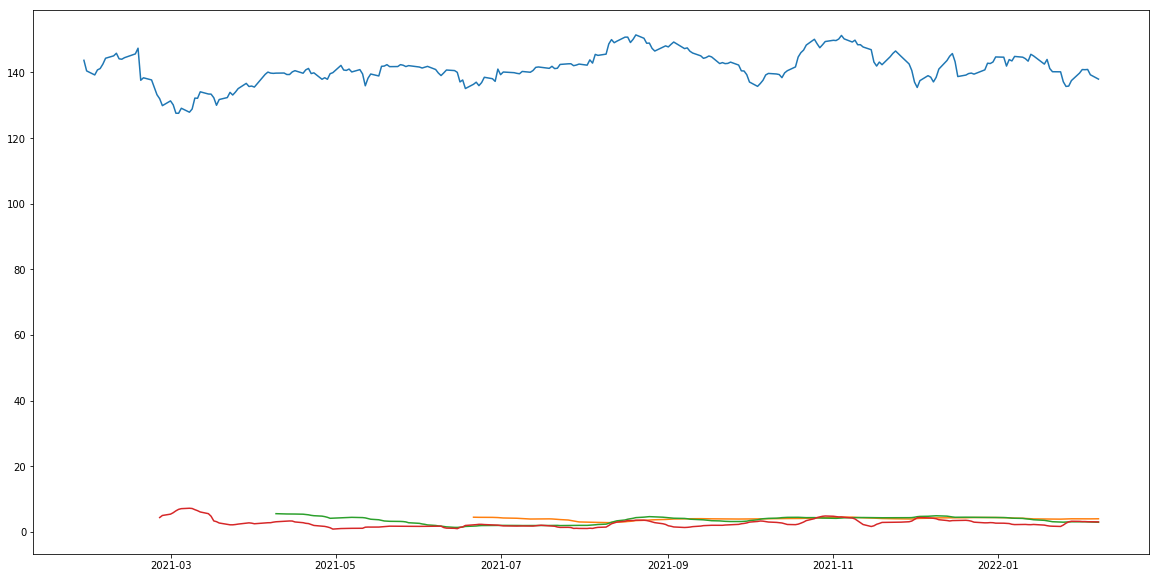

In [55]:
WMT_100_std = df_closing_prices["WMT"].rolling(window=100).std()
WMT_50_std = df_closing_prices["WMT"].rolling(window=50).std()
WMT_20_std = df_closing_prices["WMT"].rolling(window=20).std()

ax2 = df_closing_prices["WMT"].plot(figsize=(20,10))
WMT_100_std.plot(ax=ax2)
WMT_50_std.plot(ax=ax2)
WMT_20_std.plot(ax=ax2)

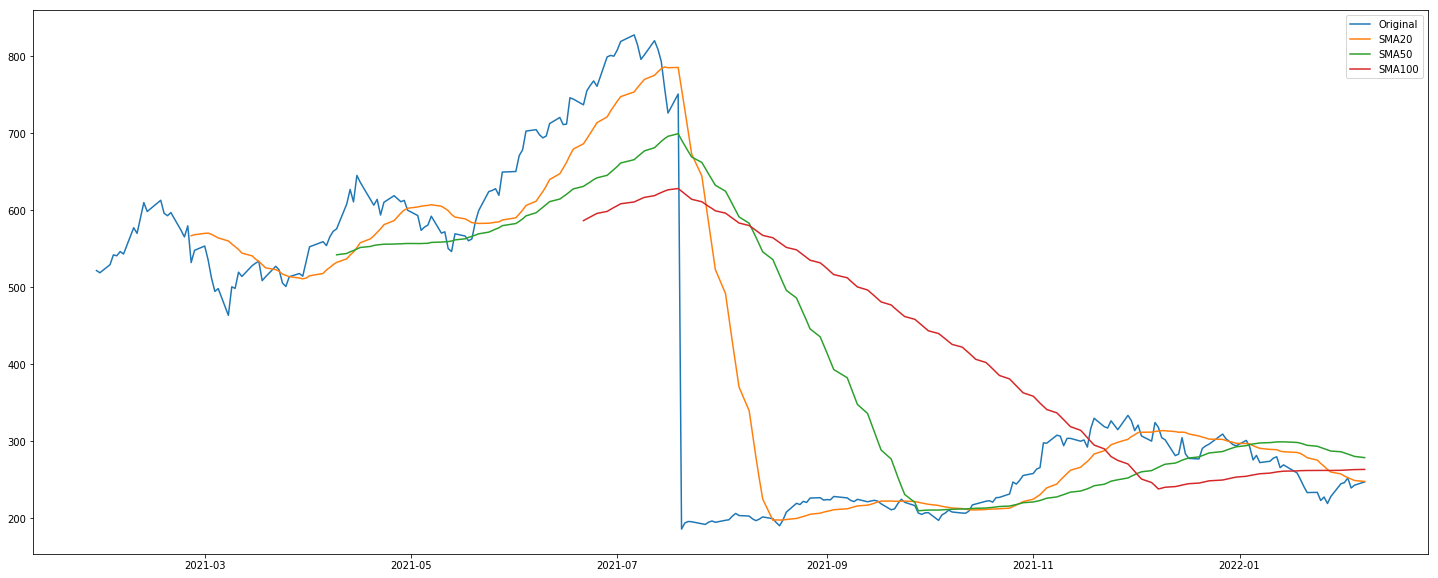

In [56]:
# Set figure of the daily closing prices of NVDA
ax = df_closing_prices["NVDA"].plot(figsize=(25,10))

# Overlay SMA20, SMA50, and SMA100 on the same figure
NVDA_sma_20.plot(ax=ax)
NVDA_sma_50.plot(ax=ax)
NVDA_sma_100.plot(ax=ax)

# Set the legend of the figure
ax.legend(["Original", "SMA20", "SMA50", "SMA100"]);

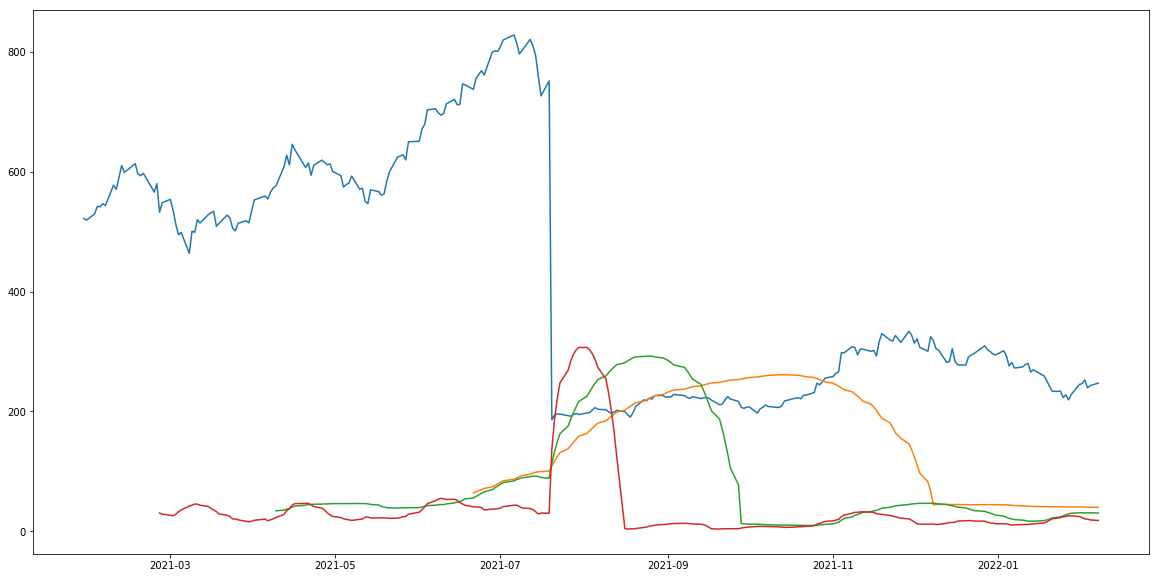

In [57]:
NVDA_100_std = df_closing_prices["NVDA"].rolling(window=100).std()
NVDA_50_std = df_closing_prices["NVDA"].rolling(window=50).std()
NVDA_20_std = df_closing_prices["NVDA"].rolling(window=20).std()

ax2 = df_closing_prices["NVDA"].plot(figsize=(20,10))
NVDA_100_std.plot(ax=ax2)
NVDA_50_std.plot(ax=ax2)
NVDA_20_std.plot(ax=ax2)

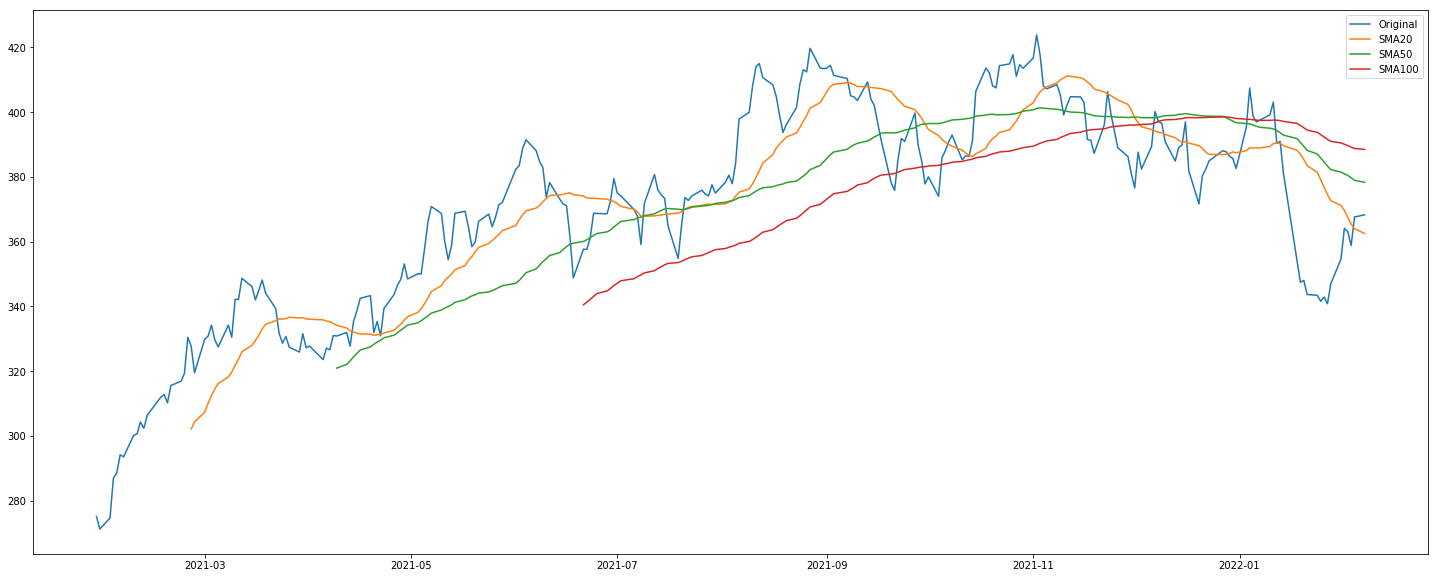

In [58]:
# Set figure of the daily closing prices of GS
ax = df_closing_prices["GS"].plot(figsize=(25,10))

# Overlay SMA20, SMA50, and SMA100 on the same figure
GS_sma_20.plot(ax=ax)
GS_sma_50.plot(ax=ax)
GS_sma_100.plot(ax=ax)

# Set the legend of the figure
ax.legend(["Original", "SMA20", "SMA50", "SMA100"]);

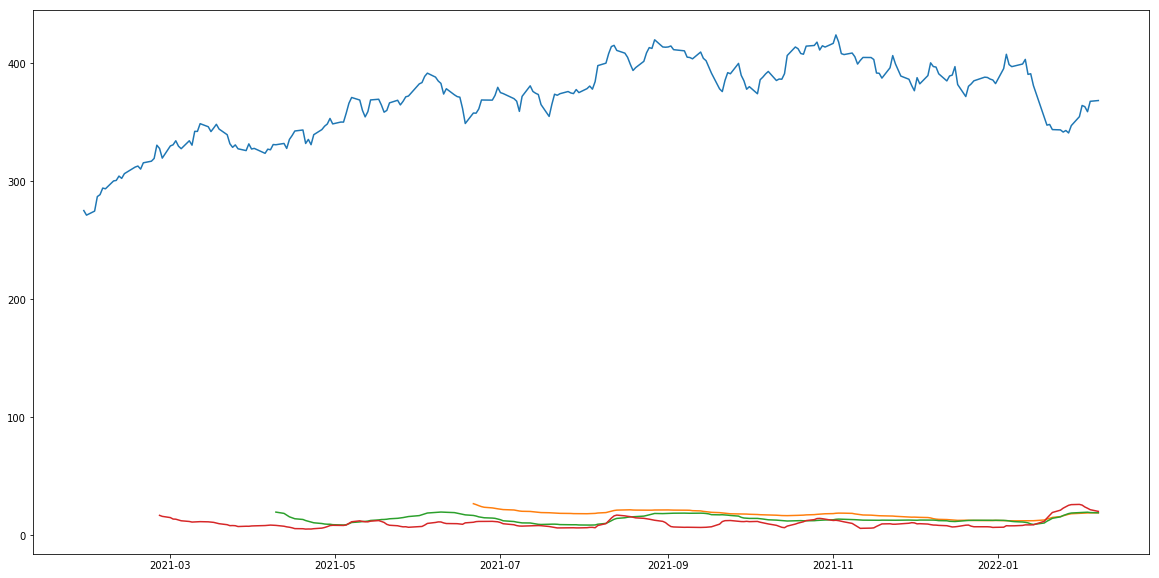

In [59]:
GS_100_std = df_closing_prices["GS"].rolling(window=100).std()
GS_50_std = df_closing_prices["GS"].rolling(window=50).std()
GS_20_std = df_closing_prices["GS"].rolling(window=20).std()

ax2 = df_closing_prices["GS"].plot(figsize=(20,10))
GS_100_std.plot(ax=ax2)
GS_50_std.plot(ax=ax2)
GS_20_std.plot(ax=ax2)

In [62]:
JMB_portfolio = df_ticker.drop(columns="SNP")
JMB_portfolio.head()

AMZN                                       \
                              open     high       low    close   volume   
time                                                                      
2021-01-28 00:00:00-05:00  3235.04  3301.68  3228.690  3239.70  2742821   
2021-01-29 00:00:00-05:00  3230.00  3236.99  3184.550  3206.31  2855494   
2021-02-01 00:00:00-05:00  3242.36  3350.26  3235.025  3342.88  3734204   
2021-02-02 00:00:00-05:00  3380.00  3427.74  3361.125  3383.23  5024907   
2021-02-03 00:00:00-05:00  3425.01  3434.00  3308.620  3311.26  6445905   

                               FB                                    ...  \
                             open    high     low   close    volume  ...   
time                                                                 ...   
2021-01-28 00:00:00-05:00  277.18  286.79  264.70  265.00  35383730  ...   
2021-01-29 00:00:00-05:00  265.30  266.56  254.85  258.33  28139673  ...   
2021-02-01 00:00:00-05:00  259.52  264.17  254.91  261.98  19629047  ...   
2021-02-02 00:00:00-05:00  264.00  268.85  263.27  267.00  15002887  ...   
2021-02-03 00:00:00-05:00  265.62  269.20  263.84  266.68  13254318  ...   

                               NVDA                                     \
                               open    high       low   close   volume   
time                                                                     
2021-01-28 00:00:00-05:00  519.8500  533.59  518.4200  521.93  5081366   
2021-01-29 00:00:00-05:00  523.0000  533.39  516.4602  519.03  6135774   
2021-02-01 00:00:00-05:00  522.1335  530.83  516.1100  529.48  4754048   
2021-02-02 00:00:00-05:00  535.9500  542.88  531.4199  542.28  4953201   
2021-02-03 00:00:00-05:00  545.4400  557.27  540.6600  541.12  5733333   

                              WMT                                       
                             open    high       low     close   volume  
time                                                                    
2021-01-28 00:00:00-05:00  144.46  146.26  143.6300  143.7000  6207997  
2021-01-29 00:00:00-05:00  143.18  143.75  140.3500  140.4693  8553315  
2021-02-01 00:00:00-05:00  140.91  141.49  139.1900  139.2400  7663421  
2021-02-02 00:00:00-05:00  139.76  142.15  139.4401  140.7700  8332687  
2021-02-03 00:00:00-05:00  140.66  142.05  140.6300  141.1900  4483616  

[5 rows x 25 columns]

In [63]:
# Configure a Monte Carlo simulation to forecast five years cumulative returns
MC_even_dist = MCSimulation(
    portfolio_data = JMB_portfolio,
    weights = [.2, .2, .2, .2, .2],
    num_simulation = 1000,
    num_trading_days = 30
)

# Print the simulation input data
MC_even_dist.portfolio_data.head()

AMZN                                       \
                              open     high       low    close   volume   
time                                                                      
2021-01-28 00:00:00-05:00  3235.04  3301.68  3228.690  3239.70  2742821   
2021-01-29 00:00:00-05:00  3230.00  3236.99  3184.550  3206.31  2855494   
2021-02-01 00:00:00-05:00  3242.36  3350.26  3235.025  3342.88  3734204   
2021-02-02 00:00:00-05:00  3380.00  3427.74  3361.125  3383.23  5024907   
2021-02-03 00:00:00-05:00  3425.01  3434.00  3308.620  3311.26  6445905   

                                            FB                          ...  \
                          daily_return    open    high     low   close  ...   
time                                                                    ...   
2021-01-28 00:00:00-05:00          NaN  277.18  286.79  264.70  265.00  ...   
2021-01-29 00:00:00-05:00    -0.010307  265.30  266.56  254.85  258.33  ...   
2021-02-01 00:00:00-05:00     0.042594  259.52  264.17  254.91  261.98  ...   
2021-02-02 00:00:00-05:00     0.012070  264.00  268.85  263.27  267.00  ...   
2021-02-03 00:00:00-05:00    -0.021273  265.62  269.20  263.84  266.68  ...   

                               NVDA                                   WMT  \
                                low   close   volume daily_return    open   
time                                                                        
2021-01-28 00:00:00-05:00  518.4200  521.93  5081366          NaN  144.46   
2021-01-29 00:00:00-05:00  516.4602  519.03  6135774    -0.005556  143.18   
2021-02-01 00:00:00-05:00  516.1100  529.48  4754048     0.020134  140.91   
2021-02-02 00:00:00-05:00  531.4199  542.28  4953201     0.024175  139.76   
2021-02-03 00:00:00-05:00  540.6600  541.12  5733333    -0.002139  140.66   

                                                                             
                             high       low     close   volume daily_return  
time                                                                         
2021-01-28 00:00:00-05:00  146.26  143.6300  143.7000  6207997          NaN  
2021-01-29 00:00:00-05:00  143.75  140.3500  140.4693  8553315    -0.022482  
2021-02-01 00:00:00-05:00  141.49  139.1900  139.2400  7663421    -0.008751  
2021-02-02 00:00:00-05:00  142.15  139.4401  140.7700  8332687     0.010988  
2021-02-03 00:00:00-05:00  142.05  140.6300  141.1900  4483616     0.002984  

[5 rows x 30 columns]

In [64]:
# Run a Monte Carlo simulation to forecast 1 years cumulative returns
MC_even_dist.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


/Users/seanendicott/Desktop/Project_1_JMB_Portfolio/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.005624,1.005069,0.989235,0.995719,1.009514,0.987863,0.996536,1.017133,1.009542,0.985141,...,0.981308,0.981801,1.022687,1.014509,0.991725,0.991824,0.999758,0.996149,0.992368,0.985984
2,0.992516,1.019974,0.994385,1.000518,1.005491,1.019724,0.988320,1.010445,1.013187,0.989001,...,0.985515,1.001519,0.992928,1.012720,1.005390,0.969721,0.973998,1.000443,1.004293,1.001602
3,0.985733,1.041445,1.006513,0.983516,1.009806,0.996864,0.981686,1.013687,1.013761,0.968141,...,0.986556,1.001094,0.997796,0.986738,0.992944,0.964982,0.990855,0.996102,1.027539,0.999473
4,0.989751,1.041366,0.983584,0.987200,1.003510,1.005124,0.982643,1.017229,1.030899,0.969105,...,0.971552,1.005823,0.982830,1.003797,1.004120,0.956369,0.980660,0.986932,1.020095,0.959108
5,0.997335,1.064105,0.977108,0.966587,1.001984,1.022503,0.948232,0.990744,1.019581,0.956199,...,0.975627,1.002209,0.978803,1.009684,0.979137,0.945883,0.977249,0.999789,1.020036,0.944488
6,0.985722,1.088116,0.974470,0.998859,1.015585,1.021656,0.925235,0.984106,1.033512,0.972653,...,0.991143,1.005770,0.969393,0.985272,0.968032,0.934351,0.988462,0.990757,1.037343,0.931165
7,1.001612,1.083968,0.972473,1.017974,1.024309,1.039626,0.923081,0.978888,1.013530,0.990691,...,1.017901,1.017634,0.980168,0.992329,0.959682,0.932694,0.993153,0.975920,1.024498,0.938682
8,0.997459,1.087949,0.969574,1.030230,1.021768,1.016229,0.927564,0.976925,1.019759,0.990883,...,1.019979,1.015004,1.000471,1.000907,0.950804,0.932211,1.017002,0.964410,1.012770,0.944385
9,1.031380,1.113830,0.970875,1.024855,1.020227,0.987261,0.923755,0.997207,1.036714,1.009142,...,1.003733,1.025872,0.995235,1.007631,0.939459,0.926808,1.004671,0.976249,1.027203,0.945363


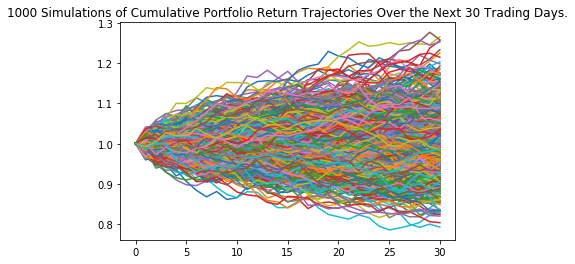

In [65]:
# Plot simulation outcomes
line_plot = MC_even_dist.plot_simulation()

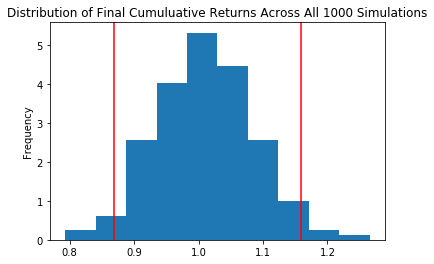

In [66]:
# Plot probability distribution and confidence intervals
dist_plot = MC_even_dist.plot_distribution()

In [67]:
# Fetch summary statistics from the Monte Carlo simulation results
even_tbl = MC_even_dist.summarize_cumulative_return()

# Print summary statistics
print(even_tbl)

count           1000.000000
mean               1.010555
std                0.074570
min                0.793210
25%                0.958167
50%                1.010891
75%                1.059911
max                1.265388
95% CI Lower       0.868635
95% CI Upper       1.158509
Name: 30, dtype: float64


In [68]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $100,000 investments in stocks
initial_investment = 100000
even_ci_lower = round(even_tbl[8]*initial_investment,2)
even_ci_upper = round(even_tbl[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of $100,000 in the portfolio"
      f" over the next 30 days will end within the range of"
      f" ${even_ci_lower} and ${even_ci_upper} with a potenetial loss of {(initial_investment-even_ci_lower).round(2)} or a potential profit of {(even_ci_upper-initial_investment).round(2)}")

There is a 95% chance that an initial investment of $100,000 in the portfolio over the next 30 days will end within the range of $86863.46 and $115850.86 with a potenetial loss of 13136.54 or a potential profit of 15850.86
